In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Big_Data_Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


spark

In [2]:
# Pyspark Libraries
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql import types as T
from pyspark.sql.types import StructField,IntegerType, StructType,StringType
from pyspark.ml.feature import StringIndexer, Imputer


#Other Libraries
import numpy as np
import pandas as pd # for creating dataframes
import matplotlib.pyplot as plt #Basic Plotting
%matplotlib inline
import seaborn as sns #Prettier Plot
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
df = spark.read.csv('C:/Users/Prateek/Documents/data-science-projects/lending_club/loan.csv', header = True, inferSchema = True)

df.count()

2260668

In [4]:
# df.take(5)

In [5]:
# These columns were not documented in the description file
df = df.drop('debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint',
       'hardship_amount', 'hardship_dpd', 'hardship_end_date',
       'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'id', 'il_util', 'inq_fi', 'inq_last_12m',
       'max_bal_bc', 'member_id', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'mths_since_rcnt_il', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m',
       'open_rv_24m', 'orig_projected_additional_accrued_interest',
       'payment_plan_start_date', 'revol_bal_joint',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line',
       'sec_app_inq_last_6mths', 'sec_app_mort_acc',
       'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts',
       'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util',
       'settlement_amount', 'settlement_date', 'settlement_percentage',
       'settlement_status', 'settlement_term', 'title', 'total_bal_il',
       'total_cu_tl', 'total_rev_hi_lim', 'url',
       'verification_status_joint', 'id', 'member_id', 'zip_code')

In [6]:
#check columns for missing values
# we drop columns with more than 30% missing values since imputing them could introduce bias in data
# droplist = []
# count = df.count()
# for col in df.columns:
#     cnt = df.filter(df[col].isNull()).count()
#     null_per = (cnt/count)*100
# #     print(col, " ", "with null values: ", cnt)
# #     print(col, " ", "with % null values: ", null_per, '%')
#     if null_per > 30:
#         droplist.append(col)

In [7]:
droplist = ['annual_inc_joint', 'all_util']

In [8]:
# we drop the columns on the drop list and all the rows with 1 or more null values 
red_df = df.drop(*droplist).na.drop()

In [9]:
red_df.count()

1669113

In [10]:
red_df.dtypes

[('loan_amnt', 'int'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'double'),
 ('installment', 'double'),
 ('grade', 'string'),
 ('sub_grade', 'string'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'string'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('loan_status', 'string'),
 ('pymnt_plan', 'string'),
 ('purpose', 'string'),
 ('addr_state', 'string'),
 ('dti', 'string'),
 ('delinq_2yrs', 'string'),
 ('earliest_cr_line', 'string'),
 ('inq_last_6mths', 'string'),
 ('open_acc', 'string'),
 ('pub_rec', 'string'),
 ('revol_bal', 'string'),
 ('revol_util', 'string'),
 ('total_acc', 'string'),
 ('initial_list_status', 'string'),
 ('out_prncp', 'string'),
 ('out_prncp_inv', 'string'),
 ('total_pymnt', 'string'),
 ('total_pymnt_inv', 'string'),
 ('total_rec_prncp', 'string'),
 ('total_rec_int', 'string'),
 ('total_rec_late_fee', 'string'),
 ('recoveries', 'string'),
 ('co

## Defaulters(our labels)

In [11]:
red_df.groupBy(['loan_status']).count().orderBy('count', ascending = False).show(10,  truncate = False)

+------------------+------+
|loan_status       |count |
+------------------+------+
|Fully Paid        |772878|
|Current           |676833|
|Charged Off       |193654|
|Late (31-120 days)|16195 |
|In Grace Period   |6850  |
|Late (16-30 days) |2678  |
|Default           |25    |
+------------------+------+



In [12]:
data = red_df.withColumn("default", 
   F.when((red_df.loan_status == 'Fully Paid') | (red_df.loan_status == 'Current') | \
          (red_df.loan_status == 'Does not meet the credit policy. Status:Fully Paid') ,0).otherwise('1'))

data = data.drop('loan_status')

data.groupBy(['default']).count().orderBy('count', ascending = False).show(10,  truncate = False)

+-------+-------+
|default|count  |
+-------+-------+
|0      |1449711|
|1      |219402 |
+-------+-------+



Text(0, 0.5, 'Number of Customers')

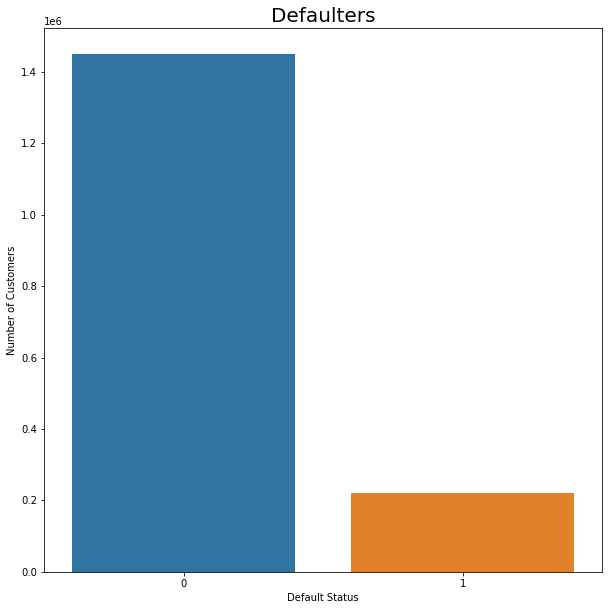

In [13]:
defaulters = data.select('default', 'int_rate', 'term').toPandas()

fig, ax = plt.subplots(figsize = (10,10))

sns.countplot(x = 'default', data = defaulters)
ax.set_title('Defaulters', fontsize = 20)
ax.set_xlabel('Default Status')
ax.set_ylabel('Number of Customers')

Only 13.1% of the borrowers have defaulted, hence the input data will be skewed. 

In real life, a lender mainly looks at 2 main thing, "Credit Score" and "Income", hence sanctioning x amount and term of the loan.(Since we dont have access to credit scoer we will explore other columns)

The purpose might be an important factor in setting in

The borrower looks at Interest rate, installment and term. 

In [16]:
red_df.groupBy(['debt_settlement_flag']).count().orderBy('count', ascending = False).show(10,  truncate = False)

+--------------------+-------+
|debt_settlement_flag|count  |
+--------------------+-------+
|N                   |1643877|
|Y                   |25236  |
+--------------------+-------+



Text(0, 0.5, 'Number of Customers')

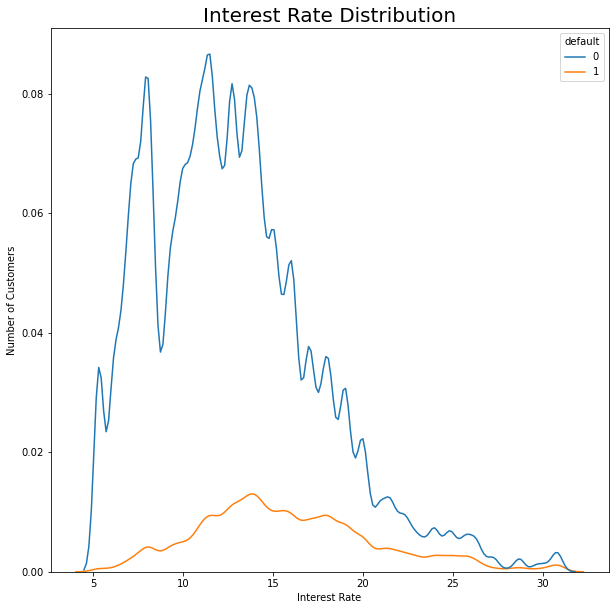

In [17]:
exp = data.select('loan_amnt', 'funded_amnt', 'int_rate','installment', 'annual_inc','term', 'default').toPandas()


fig, ax = plt.subplots(figsize = (10,10))
sns.kdeplot(data = exp, x = 'int_rate', hue = 'default')
ax.set_title('Interest Rate Distribution', fontsize = 20)
ax.set_xlabel('Interest Rate')
ax.set_ylabel('Number of Customers')

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

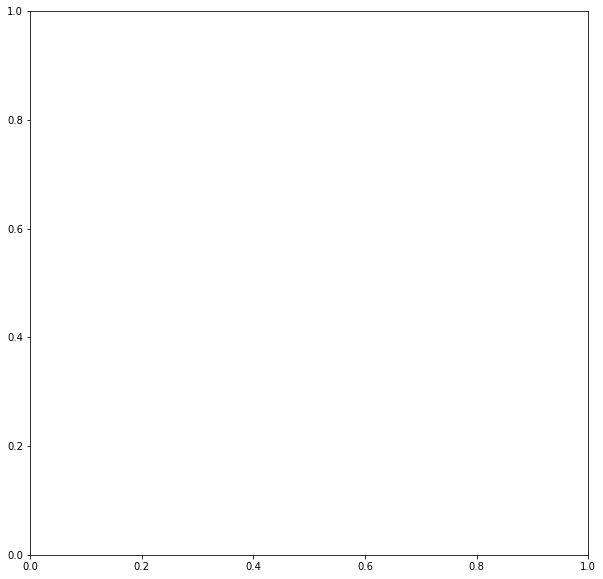

In [18]:
fig,ax = plt.subplots(figsize = (10,10))
sns.kdeplot(data = exp, x = 'annual_inc', hue = 'default')
ax.set_title('Interest Rate Distribution', fontsize = 20)
ax.set_xlabel('Interest Rate')
ax.set_ylabel('Number of Customers')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

sns.countplot(x = 'term',hue ='default', data = defaulters)
ax.set_title('Term Length Default', fontsize = 20)
ax.set_xlabel('Term Length')
ax.set_ylabel('Number of Customers')

The number of loan defaults are higher on 60 months loan term with respect to number of loans issued.

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
sns.boxplot(x= 'term', y= 'int_rate', hue='default', data= defaulters)
ax.set_title('Interest Term Length Default', fontsize = 18)
ax.set_xlabel('Term Length')
ax.set_ylabel('Interest Rates')

In [ ]:
data.groupBy(['purpose']).count().orderBy('count', ascending = False).show(50,  truncate = False)

Reasons for taking out loan

In [ ]:
data = data.withColumn("annual_inc", data["annual_inc"].cast(IntegerType()))

In [ ]:
purpose = data.select('purpose', 'annual_inc', 'int_rate', 'default').toPandas()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (10,10))
fig.subplots_adjust(hspace=0.05)

#set limits for y axis
ax1.set_ylim(200000, 900000)
ax2.set_ylim(0, 100000)

# plotting break diagonals
d = 0.025  # line length 
ax1.plot((-d, +d), (-d, +d), c='k', clip_on=False, transform=ax1.transAxes)
ax1.plot((1 - d, 1 + d), (-d, +d), c='k', clip_on=False, transform=ax1.transAxes)
ax2.plot((-d, +d), (1 - d, (1 + d)), c='k', clip_on=False, transform=ax2.transAxes)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), c='k', clip_on=False, transform=ax2.transAxes)

sns.countplot(x= 'purpose', hue='default', data= purpose)
ax1.set_title('Annual Income vs Purpose', fontsize = 18)
# ax1.set_xlabel('Purpose')
ax1.set_ylabel('Annual Income')
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)

ax2.spine
sns.countplot(x= 'purpose', hue='default', data= purpose)
# ax2.set_title('Annual Income vs Purpose', fontsize = 18)
ax2.set_xlabel('Purpose')
ax2.set_ylabel('Annual Income')
plt.xticks(rotation=45)